In [1]:
student_id =  99101579
student_name = 'Radin Khayyam'

print("your student id:", student_id)
print("your name:", student_name)

your student id: 99101579
your name: Radin Khayyam


In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt


In [3]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    # Define data transformations
    # we used torch.flatten to reshape 28*28 pics to a 784*1 vector
    transform = Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))])

    # Create training data loader
    train_dataset = MNIST('./data/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    # Create test data loader
    test_dataset = MNIST('./data/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


In [16]:
# Generate positive data
# We put correct label on first 10 pixels of data for this part
def gen_pos_data(x, y):
    x_ = x.clone()
    x_[:,0:10] = 0
    if(type(y)==int):
      for i in range(x.shape[0]):
        x_ [i , y] = 1.0
    else:
      for i in range(x.shape[0]):
        x_ [i , y[i]] = 1.0

    return x_

In [5]:
# Generate negative data
# We put random wrong label on first 10 pixels of data for this part
def gen_neg_data(x,y):
    x_ = x.clone()
    x_[:,0:10] = 0
    rand_idx = torch.randperm(x.size(0))
    y_rand = y[rand_idx]
    for i in range(x.shape[0]):
      x_ [i , y_rand[i]] = 1.0
    return x_

in this section we show an example what we did in generating positive and negative data from original data.
As you can see, in positive data we put the right label in first 10 pixels, but in negative data we put another random label in these pixels.

100%|██████████| 9912422/9912422 [00:00<00:00, 81771769.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38358357.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28001260.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16522574.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



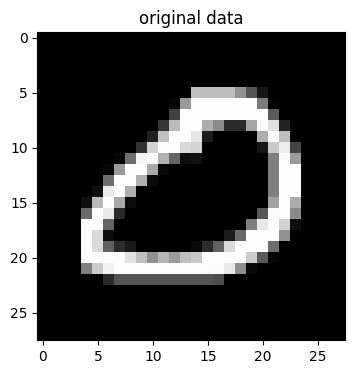

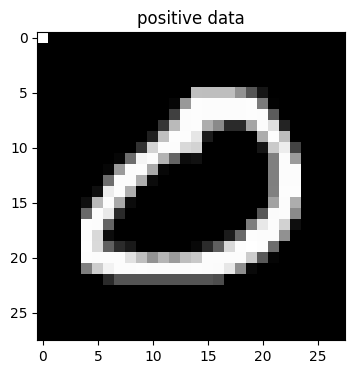

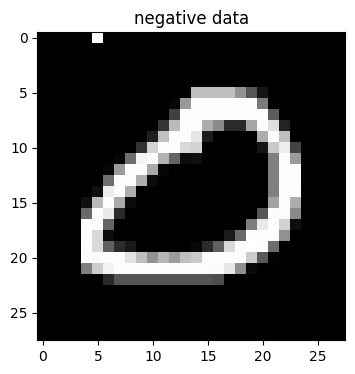

In [6]:
train_loader, test_loader = MNIST_loaders()
x, y = next(iter(train_loader))
x_pos_sample = gen_pos_data(x, y)[0]
x_neg_sample = gen_neg_data(x, y)[0]
reshaped_org = x[0].cpu().reshape(28, 28)
reshaped_pos = x_pos_sample.cpu().reshape(28, 28)
reshaped_neg = x_neg_sample.cpu().reshape(28, 28)

plt.figure(figsize = (4, 4))
plt.title('original data')
plt.imshow(reshaped_org, cmap="gray")
plt.show()

plt.figure(figsize = (4, 4))
plt.title('positive data')
plt.imshow(reshaped_pos, cmap="gray")
plt.show()

plt.figure(figsize = (4, 4))
plt.title('negative data')
plt.imshow(reshaped_neg, cmap="gray")
plt.show()

Now we need to create FF_Net and FF_Layer classes to build the Network and implement the Forward-Forward algorithm.

In [7]:
class FF_Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [FF_Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = gen_pos_data(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness.append(h.pow(2).mean(1))
            goodness_per_label.append(sum(goodness).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)


in this part we have two important function, the first one is forward in which we perform forward pass of layer. we used relu as activation function. second function is train, in this function firstly we derived goodness of positive and negative data, then we used a custom loss function as mentioned in question.
**this loss function is suitable for this algorithm because "the aim of the learning is to make the goodness be well above some thereshold value for real data and well below that value for negative data".** with minimizing this loss function we can reach this goal.
in the last part, with using of gradient decent we updated the parameters in a way that minimizing loss function of this layer it self.

In [8]:
class FF_Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # Find goodness of positive and negative data
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # Compute Loss function
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [17]:
torch.manual_seed(23)
train_loader, test_loader = MNIST_loaders()

net = FF_Net([784, 500, 500])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x_pos = gen_pos_data(x, y)
x_neg = gen_neg_data(x, y)


net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

training layer 0 ...


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:39<00:00, 25.09it/s]


train error: 0.08062005043029785
test error: 0.08140003681182861
